<a href="https://colab.research.google.com/github/marcelounb/tensorflow_udacity/blob/master/04_dogs_vs_cats_cnn_with_image_augmentation_and_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import Sequential 
from keras.layers import Dense 
from keras.layers import Dropout 
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.optimizers import SGD

# Imports for the CNN
from keras.layers import Flatten 
from keras.layers.convolutional import Convolution2D 
from keras.layers.convolutional import MaxPooling2D
from keras import backend as K 
from random import randrange

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import os

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 3s 0us/step


In [4]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train/cats


In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

In [6]:
base_dir, train_dir, validation_dir, train_cats_dir, train_dogs_dir, validation_cats_dir, validation_dogs_dir

('/root/.keras/datasets/cats_and_dogs_filtered',
 '/root/.keras/datasets/cats_and_dogs_filtered/train',
 '/root/.keras/datasets/cats_and_dogs_filtered/validation',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/cats',
 '/root/.keras/datasets/cats_and_dogs_filtered/train/dogs',
 '/root/.keras/datasets/cats_and_dogs_filtered/validation/cats',
 '/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs')

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
num_cats_tr, num_dogs_tr, num_cats_val, num_dogs_val ,total_train, total_val

(1000, 1000, 500, 500, 2000, 1000)

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters
For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [10]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Augmentation
Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In tf.keras we can implement this using the same ImageDataGenerator class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

To start off, let's define a function that can display an image, so we can see the type of augmentation that has been performed. Then, we'll look at specific augmentations that we'll use during training.

In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# Flipping the image horizontally
We can begin by randomly applying horizontal flip augmentation to our dataset and seeing how individual images will look after the transformation.

 This is achieved by passing horizontal_flip=True as an argument to the ImageDataGenerator class.

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's take one sample image from our training set and repeat it five times. The augmentation will be randomly applied (or not) to each repetition.

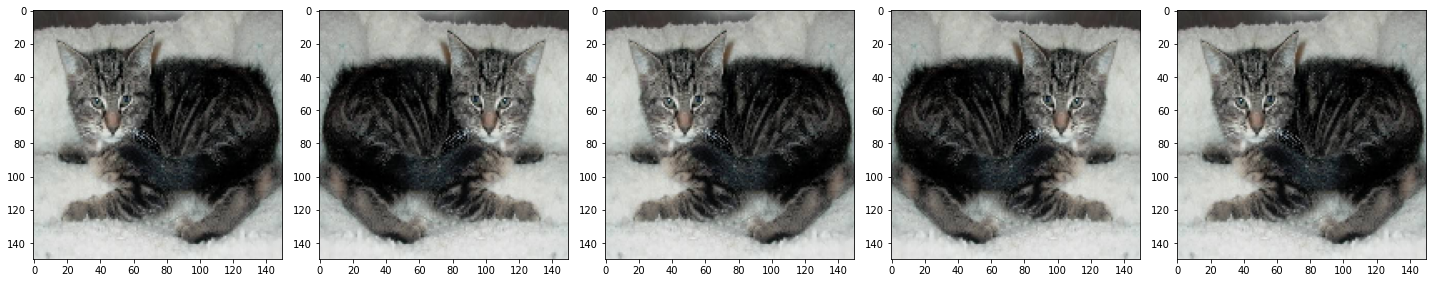

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Rotating the image
The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [14]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


To see the transformation in action, let's once again take a sample image from our training set and repeat it. 

The augmentation will be randomly applied (or not) to each repetition.

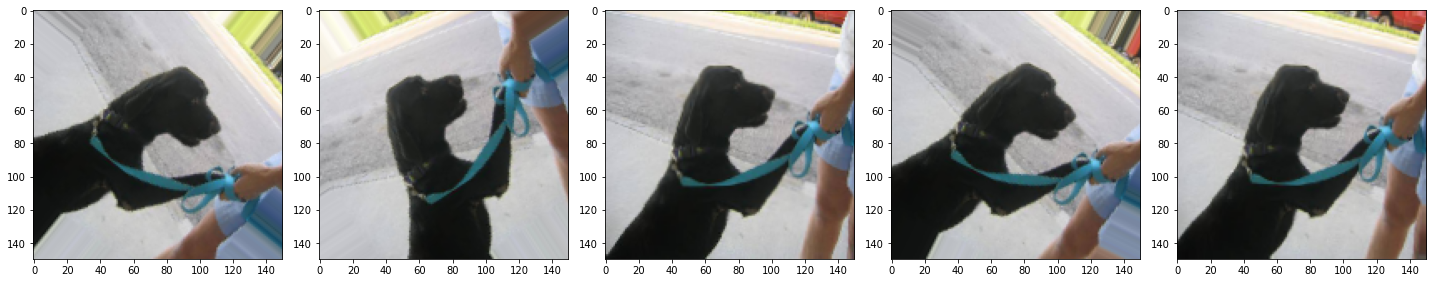

In [15]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Applying Zoom
We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [16]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 2000 images belonging to 2 classes.


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

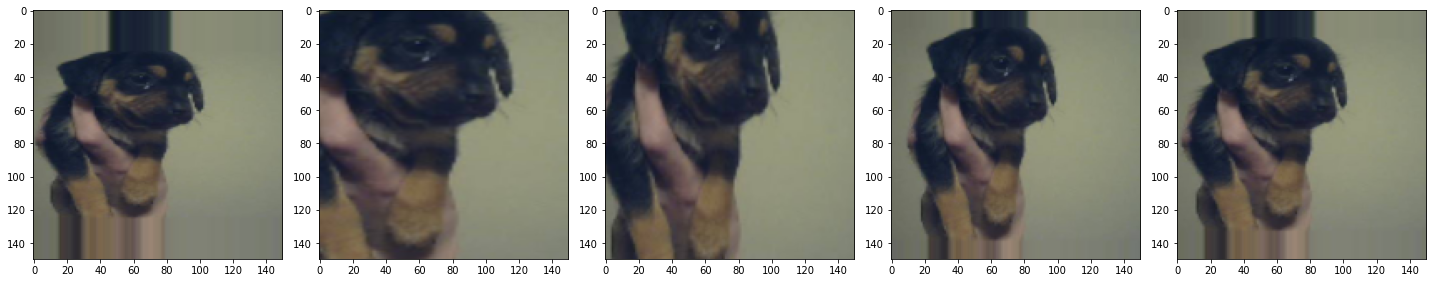

In [17]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

Putting it all together
We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.


Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [18]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset.

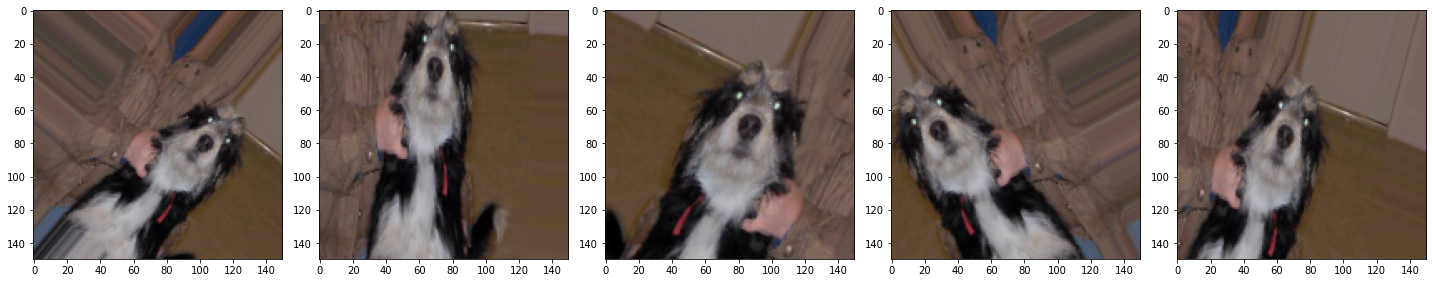

In [19]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

# Creating Validation Data generator
Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. 

So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [20]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


# Model Creation

# Define the model
The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a relu activation function. The model will output class probabilities for two classes — dogs and cats — using softmax

In [28]:
def cnn_model_my_way():
  # create model 
  model = Sequential() 
  model.add(Convolution2D(32, (3, 3), input_shape=(150, 150, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(64, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Convolution2D(128, (3, 3), activation= 'relu' )) 
  model.add(MaxPooling2D((2, 2)))

  model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dense(2))

  # Compile model 
  model.compile(loss= 'sparse_categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ]) 
  return model

In [29]:
model = cnn_model_my_way()

# Compiling the model
As usual, we will use the adam optimizer. Since we output a softmax categorization, we'll use sparse_categorical_crossentropy as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Summary
Let's look at all the layers of our network using summary method.

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

# Train the model
It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [32]:
epochs=35
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/35
20/20 [==============================] - 104s 5s/step - loss: 0.6982 - accuracy: 0.5225 - val_loss: 0.6867 - val_accuracy: 0.5070
Epoch 2/35
20/20 [==============================] - 103s 5s/step - loss: 0.6933 - accuracy: 0.5020 - val_loss: 0.6886 - val_accuracy: 0.6100
Epoch 3/35
20/20 [==============================] - 104s 5s/step - loss: 0.6880 - accuracy: 0.5520 - val_loss: 0.6743 - val_accuracy: 0.5420
Epoch 4/35
20/20 [==============================] - 107s 5s/step - loss: 0.6833 - accuracy: 0.5660 - val_loss: 0.6729 - val_accuracy: 0.5270
Epoch 5/35
20/20 [==============================] - 103s 5s/step - loss: 0.6588 - accuracy: 0.6055 - val_loss: 0.6256 - val_accuracy: 0.6310
Epoch 6/35
20/20 [==============================] - 103s 5s/step - loss: 0.6582 - accuracy: 0.6020 - val_loss: 0.5959 - val_accuracy: 0.6890
Epoch 7/35
20/20 [==============================] - 103s 5s/step - loss: 0.6535 - accuracy: 0.6050 - val_loss: 0.6280 - val_accuracy: 0.6290
Epoch 8/35
20

# Visualizing results of the training
We'll now visualize the results we get after training our network.

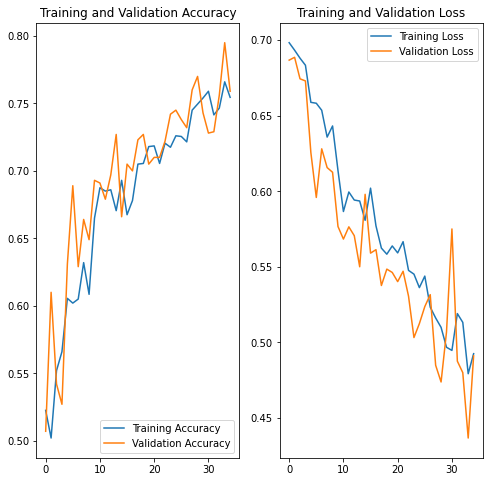

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()